# Linear Tree

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from lineartree import LinearTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from joblib import dump
from sklearn.tree import plot_tree
import numpy as np
from scipy.spatial.distance import euclidean

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.classification_metrics import classification

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/software_defect.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/software_defect.parquet')

In [5]:
y_train = train.defects
X_train = train.drop(columns=['defects'])

In [6]:
y_validation = validation.defects
X_validation = validation.drop(columns=['defects'])

In [7]:
scaler = StandardScaler().fit(X_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [36]:
max_depth = [1, 2, 3, 4, 5, 7, 10, 12, 15]
base_est = [LogisticRegression(penalty=None, max_iter=300), LogisticRegression(max_iter=500)]

We are not including Lasso neither ElasticNet regressions at the leaves because run times are too long.

In [37]:
models_list = []
names_list = []
for i in max_depth:
    for est in base_est:
        models_list.append(LinearTreeClassifier(base_estimator=est, max_depth=i))
        if est.penalty == None:
            names_list.append('LT_'+str(i))
        else:
            names_list.append('LT_'+str(i)+'_'+str(est.penalty))

In [49]:
metrics = classification(models_list, names_list, '../../../data/metrics/software_defect/linear_tree.csv', X_train_scaled, y_train, X_validation_scaled, y_validation)
metrics

,Run_Time,Train_AUC,Validation_AUC,delta%
LT_1_l2,165.874027,0.787244,0.786922,-0.040866
LT_2,226.643227,0.788874,0.788094,-0.098880
LT_2_l2,200.939272,0.788948,0.788188,-0.096331
LT_3,256.453573,0.789908,0.789305,-0.076285
LT_3_l2,211.179203,0.789504,0.789139,-0.046232
LT_4,267.534374,0.790699,0.790243,-0.057646
LT_4_l2,214.007976,0.790237,0.790030,-0.026164
LT_5,273.584924,0.790876,0.790491,-0.048681
LT_5_l2,212.932756,0.790427,0.790298,-0.016273
LT_7,274.714967,0.791951,0.791520,-0.054362


In [52]:
metrics.sort_values(by='Validation_AUC', ascending=False)

,Run_Time,Train_AUC,Validation_AUC,delta%
LT_7,274.714967,0.791951,0.791520,-0.054362
LT_10,273.680788,0.791951,0.791520,-0.054362
LT_12,274.348933,0.791951,0.791520,-0.054362
LT_15,271.853729,0.791951,0.791520,-0.054362
LT_5,273.584924,0.790876,0.790491,-0.048681
LT_15_l2,275.038857,0.790427,0.790298,-0.016273
LT_5_l2,212.932756,0.790427,0.790298,-0.016273
LT_7_l2,214.867577,0.790427,0.790298,-0.016273
LT_10_l2,212.605409,0.790427,0.790298,-0.016273
LT_12_l2,212.571766,0.790427,0.790298,-0.016273


The first 4 models that appear in the list are exactly the same, they are trees of depth 7. Let's keep working with **LT_7**

In [58]:
test =  pd.read_parquet('../../../data/model_input/test_sets/software_defect.parquet')

In [59]:
y_test = test.defects
X_test = test.drop(columns=['defects'])

In [60]:
retrain = pd.concat([train, validation])

In [61]:
y_retrain = retrain.defects
X_retrain = retrain.drop(columns=['defects'])

In [63]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [64]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [65]:
model = LinearTreeClassifier(base_estimator=LogisticRegression(penalty=None, max_iter=300), max_depth=7).fit(X_retrain_scaled, y_retrain)

In [66]:
test_pred = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, test_pred)
print('Test AUC:', round(auc, 4))

Test AUC: 0.7904


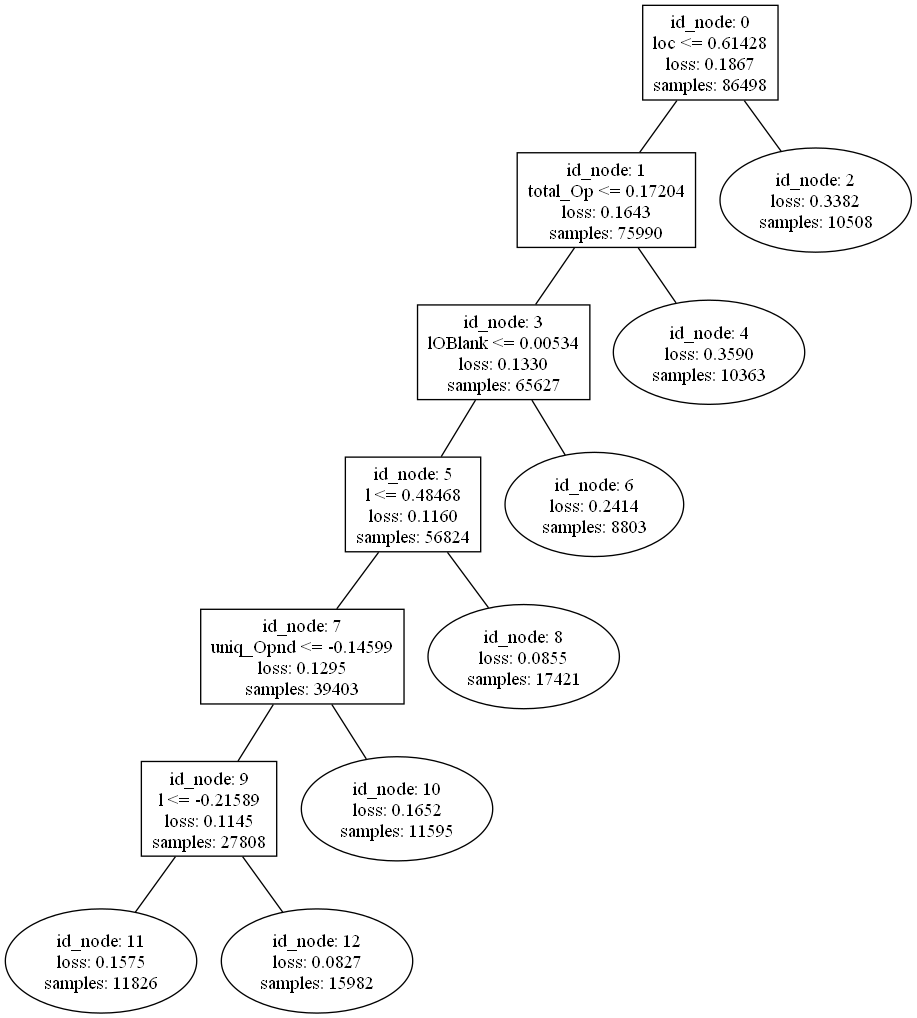

In [68]:
model.plot_model(feature_names=X_retrain.columns)

In [69]:
dump(model, 'best_linear_tree.joblib')

['best_linear_tree.joblib']

In [70]:
with open('../../../data/metrics/software_defect/final_AUC.txt', 'a') as f:
    f.write('\nLT, '+ str(auc))

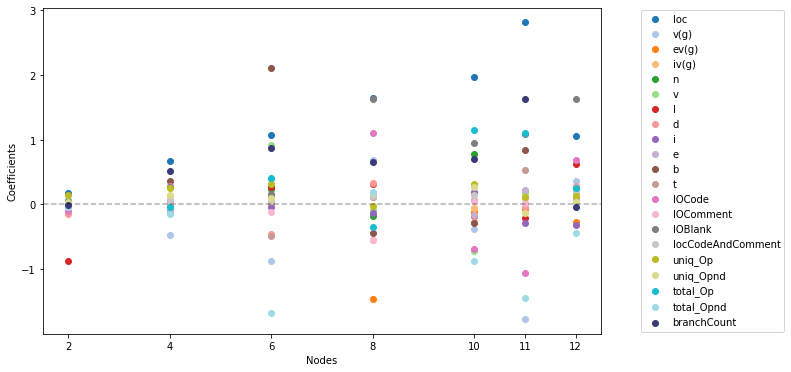

In [84]:
leaves = model.summary(only_leaves=True)
x_values = list(leaves.keys())
coefs_values = []

for i in range(X_retrain.shape[1]):
    coef = []
    for el in leaves.values():
        coef.append([el['models'].coef_[0][i]])
    coefs_values.append(coef)

num_colors = len(X_retrain.columns)
maps_colors = ['tab20', 'tab20b']
colors = []

for map_color in maps_colors:
    cmap = plt.get_cmap(map_color)
    colors.extend([cmap(i) for i in np.linspace(0, 1, cmap.N)])

colors = colors[:num_colors]    

plt.figure(figsize=(10,6))
for i in range(len(coefs_values)):
    plt.scatter(list(x_values), coefs_values[i], label=X_retrain.columns[i], color=colors[i])
plt.axhline(0, c='black', linestyle='--', alpha=0.3)
plt.ylabel('Coefficients')
plt.xlabel('Nodes')
plt.legend(loc='center', bbox_to_anchor=(1.2, 0.5))
plt.xticks(list(x_values))
plt.show()